In [14]:
%matplotlib inline

import os,sys
root = os.path.realpath(os.path.join(os.getcwd(), ".."))
sys.path.append(root)

from common import *
from common.notebook_utils import *
from common.scoring import calculate_fid_given_images


checkpoint_dir, data_dir = paths("leaky")
last_checkpoint_epoch = 155
seed(999)

Random Seed:  999


In [15]:
fresh_start = False

In [16]:
# Root directory for dataset
dataroot = "data/dogs"

# Directory for checkpointing model and parameters state
checkpointsroot = "checkpoints/dogsLeaky"

# Number of workers for dataloader
num_workers = 2

# Batch size during training
batch_size = 32

# Spatial size of training images. All images will be resized to this size using a transformer.
image_size = 128

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 16

# Number of training epochs
num_epochs = 0

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.

ngpu = 1

In [17]:
print(torch.cuda.is_available())
print(torch.version.cuda)

False
10.1


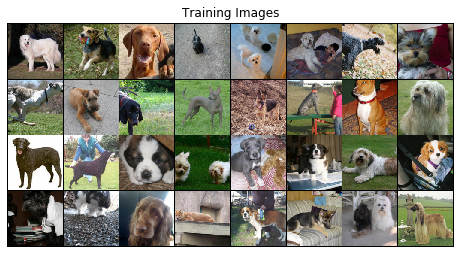

In [18]:
# Create the dataloader
dataloader = make_dataloader(data_dir, image_size, batch_size, num_workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
plot_training_images(dataloader, device)

In [19]:
print(device)

cpu


In [20]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# Generator Code

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 16, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 16),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ngf*16) x 4 x 4
            nn.ConvTranspose2d(ngf * 16, ngf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ngf*8) x 8 x 8
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ngf*4) x 16 x 16 
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ngf*2) x 32 x 32
            nn.ConvTranspose2d(ngf * 2,     ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ngf) x 64 x 64
            nn.ConvTranspose2d(    ngf,      nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 128 x 128
        )

    def forward(self, input):
        return self.main(input)
    
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 128 x 128
            nn.Conv2d(nc, ndf, 4, stride=2, padding=1, bias=False), 
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 64 x 64
            nn.Conv2d(ndf, ndf * 2, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 32 x 32
            nn.Conv2d(ndf * 2, ndf * 4, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 16 x 16 
            nn.Conv2d(ndf * 4, ndf * 8, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 8 x 8
            nn.Conv2d(ndf * 8, ndf * 16, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ndf * 16),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*16) x 4 x 4
            nn.Conv2d(ndf * 16, 1, 4, stride=1, padding=0, bias=False),
            nn.Sigmoid()
            # state size. 1
        )

    def forward(self, input):
        return self.main(input)

In [21]:
# Start epoch
start_epoch = 0

# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG.apply(weights_init)

# Print the model
#print(netG)

# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
#print(netD)

# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

G_losses = []
D_losses = []
iters = 0

if not fresh_start:
    start_epoch, netG, netD, criterion, fixed_noise, optimizerG, optimizerD, G_losses, D_losses, iters = load_checkpoint(netG, netD, criterion, fixed_noise, optimizerG, optimizerD, G_losses, D_losses, iters, join(checkpoint_dir,  f"state_{last_checkpoint_epoch}.pth"), device)
    netG.to(device)
    netD.to(device)
    
    # now individually transfer the optimizer parts...
    for state in optimizerG.state.values():
        for k, v in state.items():
            if isinstance(v, torch.Tensor):
                state[k] = v.to(device)

    # now individually transfer the optimizer parts...
    for state in optimizerD.state.values():
        for k, v in state.items():
            if isinstance(v, torch.Tensor):
                state[k] = v.to(device)


# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

=> loading checkpoint 'C:\Users\Kumo\Documents\GitHub\dogganit\checkpoints\leaky\state_155.pth'
=> loaded checkpoint 'C:\Users\Kumo\Documents\GitHub\dogganit\checkpoints\leaky\state_155.pth' (epoch 156)


In [22]:
# Training Loop

total_epochs = start_epoch + num_epochs

# Lists to keep track of progress
img_list = []

print("Starting Training Loop...")
# For each epoch
for epoch in range(start_epoch, total_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, total_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1
    
    if np.mod(epoch, checkpoint_period) == 0:
        state = {
                'epoch': epoch + 1,
                'netG_state_dict': netG.state_dict(),
                'netD_state_dict': netD.state_dict(),
                'criterion': criterion,
                'fixed_noise': fixed_noise,  
                'optimizerG_state_dict': optimizerG.state_dict(),
                'optimizerD_state_dict': optimizerD.state_dict(),
                'G_losses': G_losses,
                'D_losses': D_losses,
                'iters': iters
                }
        torch.save(state, '%s/state_%d.pth' % (checkpoint_dir, epoch))

Starting Training Loop...


C:\Users\Kumo\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


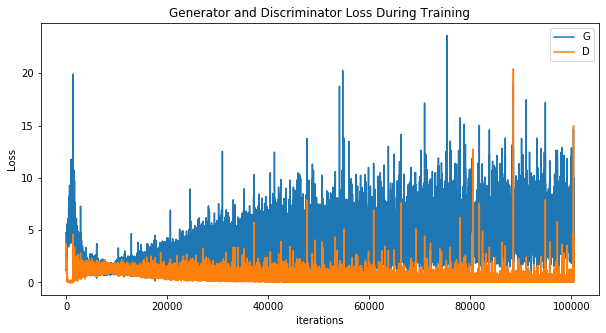

In [23]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

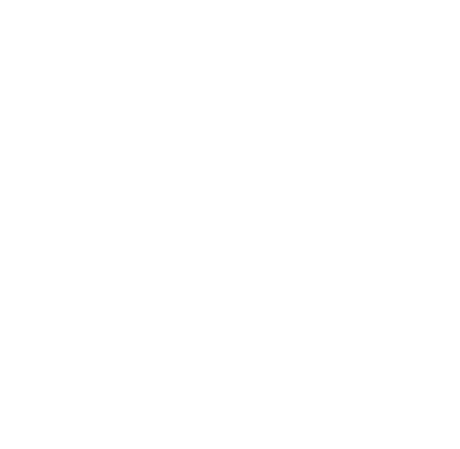

In [24]:
#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

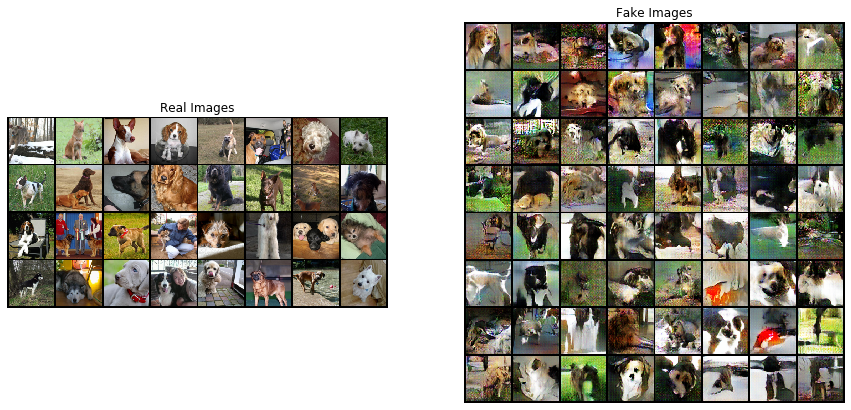

In [25]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
fake_images = generate_images(netG, nz, num_images = batch_size)
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(vutils.make_grid(fake_images[-1].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))
plt.show()

In [26]:
calculate_fid_given_images([real_batch[0][0:64].numpy(), fake_images[-1].numpy()], batch_size = batch_size)

spinning up model
done with super!
spun up!
batch size:  32
num images:  32


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

tensor([[[[ 0.5922,  0.7490,  0.0510,  ...,  0.8588,  0.7490,  0.9451],
          [ 0.6941,  0.8118,  0.0353,  ...,  0.8118,  0.6941,  0.9294],
          [ 0.9216,  0.7725,  0.0353,  ...,  0.7804,  0.6706,  0.8980],
          ...,
          [ 0.0118,  0.1294,  0.1216,  ...,  0.9686,  0.9451,  0.9451],
          [ 0.3255,  0.2784,  0.3098,  ...,  0.9373,  0.9294,  0.9373],
          [ 0.5529,  0.5216,  0.5529,  ...,  0.9373,  0.9294,  0.9373]],

         [[ 0.5529,  0.7569,  0.0745,  ...,  0.8980,  0.7804,  0.9922],
          [ 0.6471,  0.8196,  0.0667,  ...,  0.8745,  0.7412,  0.9922],
          [ 0.8980,  0.8039,  0.0667,  ...,  0.8588,  0.7412,  0.9922],
          ...,
          [-0.0118,  0.1686,  0.1608,  ...,  0.9922,  1.0000,  0.9922],
          [ 0.3490,  0.3647,  0.4039,  ...,  1.0000,  1.0000,  1.0000],
          [ 0.5843,  0.6078,  0.6392,  ...,  1.0000,  1.0000,  1.0000]],

         [[ 0.6078,  0.7333, -0.0275,  ...,  0.9608,  0.8667,  0.9451],
          [ 0.6706,  0.8039, -

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.87s/it]


batch size:  32
num images:  64


  0%|                                                                                            | 0/2 [00:00<?, ?it/s]

tensor([[[[-0.2732, -0.1499, -0.1271,  ...,  0.0344, -0.0276,  0.0504],
          [-0.2330, -0.0920, -0.1729,  ...,  0.0107, -0.0187,  0.0129],
          [-0.1424, -0.1236, -0.1742,  ..., -0.0279,  0.0565, -0.0047],
          ...,
          [ 0.2852,  0.4359,  0.3311,  ..., -0.6131, -0.6851, -0.5350],
          [ 0.2749,  0.4171,  0.2593,  ..., -0.6244, -0.6851, -0.5101],
          [ 0.2852,  0.2653,  0.2085,  ..., -0.6183, -0.5973, -0.4624]],

         [[-0.2744, -0.1888, -0.2277,  ...,  0.1161, -0.0645,  0.0365],
          [-0.2008, -0.1412, -0.1903,  ...,  0.1540,  0.0177,  0.0868],
          [-0.2439, -0.1321, -0.2647,  ...,  0.0830,  0.0781,  0.0122],
          ...,
          [ 0.2905,  0.4558,  0.3542,  ..., -0.5415, -0.5640, -0.5168],
          [ 0.3016,  0.3735,  0.1475,  ..., -0.6382, -0.6757, -0.4769],
          [ 0.2504,  0.3548,  0.1673,  ..., -0.5787, -0.5830, -0.4809]],

         [[-0.3324, -0.3154, -0.2246,  ..., -0.0969, -0.1618,  0.0096],
          [-0.2044, -0.2787, -

ValueError: could not broadcast input array from shape (32,4096) into shape (32,2048)